In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# car params
mass = 250 #kg
cg_height = .3 #m
tw = 1.3 #m
wb = 1.525 #m
front_wb = .839 #m
back_wb = wb - front_wb #m

g = 9.81

def tire_loads(m, long_g, lat_g, cg_h, wheelbase, front_wb, track):

    back_wb = wheelbase - front_wb

    ax = long_g * g
    ay = lat_g * g

    # static axle loads
    front_static = m * g * back_wb / wheelbase
    rear_static  = m * g * front_wb / wheelbase

    # longitudinal
    dFx = m * ax * cg_h / wheelbase

    front_axle = front_static + dFx
    rear_axle  = rear_static  - dFx

    # lateral
    dFy_total = m * ay * cg_h / track

    # lateral distribution ASSUMPTION (reality would be based on suspension + chassis roll stiffness)
    front_frac = back_wb / wheelbase
    rear_frac  = front_wb / wheelbase

    dFy_front = dFy_total * front_frac
    dFy_rear  = dFy_total * rear_frac

    FR = front_axle / 2 + dFy_front / 2
    FL = front_axle / 2 - dFy_front / 2
    RR = rear_axle  / 2 + dFy_rear  / 2
    RL = rear_axle  / 2 - dFy_rear  / 2

    return FL, FR, RL, RR

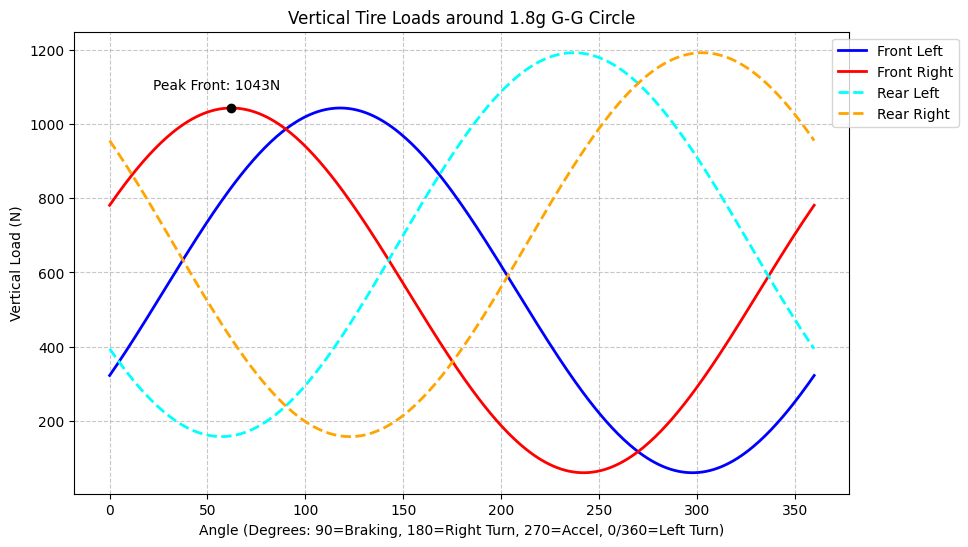

62.172701949860716


In [31]:
max_g = 1.8

# g-g circle
angles = np.linspace(0, 2 * np.pi, 360)  # 0 to 360 degrees
fl_loads = []
fr_loads = []
rl_loads = []
rr_loads = []


for theta in angles:
    lat_g = max_g * np.cos(theta)
    long_g = max_g * np.sin(theta)
    
    fl_load,fr_load,rl_load,rr_load= tire_loads(mass, long_g, lat_g, cg_height, wb, front_wb, tw)
    fl_loads.append(fl_load)
    fr_loads.append(fr_load)
    rl_loads.append(rl_load)
    rr_loads.append(rr_load)

# Convert to numpy arrays
fl_loads, fr_loads = np.array(fl_loads), np.array(fr_loads)
rl_loads, rr_loads = np.array(rl_loads), np.array(rr_loads)
angles_deg = np.degrees(angles)

# Modified Plotting Section
plt.figure(figsize=(10, 6))
plt.plot(angles_deg, fl_loads, label='Front Left', color='blue', lw=2)
plt.plot(angles_deg, fr_loads, label='Front Right', color='red', lw=2)
plt.plot(angles_deg, rl_loads, label='Rear Left', color='cyan', lw=2, linestyle='--')
plt.plot(angles_deg, rr_loads, label='Rear Right', color='orange', lw=2, linestyle='--')

plt.title(f"Vertical Tire Loads around {max_g}g G-G Circle")
plt.xlabel("Angle (Degrees: 90=Braking, 180=Right Turn, 270=Accel, 0/360=Left Turn)")
plt.ylabel("Vertical Load (N)")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle='--', alpha=0.7)

plt.scatter(angles_deg[fr_loads.argmax()], fr_loads.max(), color='black', zorder=5)
plt.annotate(f'Peak Front: {fr_loads.max():.0f}N', 
             xy=(angles_deg[fr_loads.argmax()], fr_loads.max()), 
             xytext=(angles_deg[fr_loads.argmax()]-40, fr_loads.max()+50))
            #  arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print(angles_deg[fr_loads.argmax()])

In [21]:
# |||| Link Force Calculations ||||

# define points from cad for front right tire

# L or U lower or upper
# F or R front or rear
# c or o chassis or outboard

# lower front ca
LFc = np.array([0.255, -0.2216, 0])
LFo = np.array([0, -0.563 , -0.0016])

# lower rear ca
LRc = np.array([0.00146, -0.2216, 0])
LRo = LFo

# upper front ca
UFc = np.array([0.255, -0.26, 0.18])
UFo = np.array([-0.0255, -0.533 , 0.186])

# upper rear ca
URc = np.array([-0.0146, -0.26, 0.18])
URo = UFo

# pushrod
Pc = np.array([0.014, -0.235, 0.427])
Po = np.array([0.014, -0.525, 0.024])

# tie rod
Tc = np.array([0.104, -0.24, 0.073])
To = np.array([0.063, -0.59, 0.05])

# contact patch
# CP = np.array([0.0, -0.614, -0.132]) # CAD value
CP = np.array([0.0, -0.614, 0]) # test value

In [22]:
def link_loads(Fx, Fy, Fz):
    # tire forces from G-G and tire data
    Fz_val = Fz
    # constants are from tire data Fx/Fz  = 2.91 and Fy/Fz = 2.99
    # used other constants/values to get closer to realistic performance observed in comp with some safety margin
    Fx_val = Fx
    Fy_val = Fy

    # from upright to chassis
    # positive force = tension/ away from upright
    def unit_vec(p_outboard, p_chassis):
        v = p_chassis - p_outboard
        return v / np.linalg.norm(v)

    # link directions
    LF_dir = unit_vec(LFo, LFc)
    LR_dir = unit_vec(LRo, LRc)
    UF_dir = unit_vec(UFo, UFc)
    UR_dir = unit_vec(URo, URc)
    Push_dir = unit_vec(Po, Pc)
    Tie_dir = unit_vec(To, Tc)

    # r is origin to upright link
    # moment = r x F_unit_vector
    LF_m = np.cross(LFo, LF_dir)
    LR_m = np.cross(LRo, LR_dir)
    UF_m = np.cross(UFo, UF_dir)
    UR_m = np.cross(URo, UR_dir)
    Push_m = np.cross(Po, Push_dir)
    Tie_m = np.cross(To, Tie_dir)

    # static balance matrix
    A = np.array([
        [LF_dir[0], LR_dir[0], UF_dir[0], UR_dir[0], Push_dir[0], Tie_dir[0]],
        [LF_dir[1], LR_dir[1], UF_dir[1], UR_dir[1], Push_dir[1], Tie_dir[1]],
        [LF_dir[2], LR_dir[2], UF_dir[2], UR_dir[2], Push_dir[2], Tie_dir[2]],
        [LF_m[0],   LR_m[0],   UF_m[0],   UR_m[0],   Push_m[0],   Tie_m[0]],
        [LF_m[1],   LR_m[1],   UF_m[1],   UR_m[1],   Push_m[1],   Tie_m[1]],
        [LF_m[2],   LR_m[2],   UF_m[2],   UR_m[2],   Push_m[2],   Tie_m[2]]
    ])

    # forces from tire and moments created by r (origin to contact patch) x tire forces
    F_tire = np.array([Fx_val, Fy_val, Fz_val])
    M_tire = np.cross(CP, F_tire)

    # solve
    B = np.concatenate([F_tire, M_tire])
    member_forces = np.linalg.solve(A, -B)

    labels = ["Lower Front", "Lower Rear", "Upper Front", "Upper Rear", "Pushrod", "Tie Rod"]
    for label, force in zip(labels, member_forces):
        print(f"{label}: {force:.2f} N")


In [ ]:
# positive Fx is accel, negative is brake (picture dragging steering axis through mud for braking to get directions right, front CA link would be in tension)
# positive Fy is left, negative is right

# from tire data:
# Fx/Fz max  = 2.91
# Fy/Fz max = 2.99
print(fr_loads.max())

# max braking
Fz = fr_loads.max()
Fx = Fz * -2.91
Fy = Fz * 0
link_loads(Fx, Fy, Fz)

1042.5717631602467
Lower Front: 4836.06 N
Lower Rear: -4104.33 N
Upper Front: -69.77 N
Upper Rear: -953.82 N
Pushrod: -1479.90 N
Tie Rod: 2114.41 N


In [ ]:
# positive Fx is accel, negative is brake (picture dragging steering axis through mud for braking to get directions right, front CA link would be in tension)
# positive Fy is left, negative is right

# max turning left
Fz = fr_loads.max()
Fx = Fz * 0
Fy = Fz * 2.99
link_loads(Fx, Fy, Fz)

Lower Front: 152.52 N
Lower Rear: -2049.34 N
Upper Front: -90.36 N
Upper Rear: -344.75 N
Pushrod: -1281.58 N
Tie Rod: -34.53 N


In [ ]:
# positive Fx is accel, negative is brake (picture dragging steering axis through mud for braking to get directions right, front CA link would be in tension)
# positive Fy is left, negative is right

# max turning right
Fz = fr_loads.max()
Fx = Fz * 0
Fy = Fz * -2.99
link_loads(Fx, Fy, Fz)

Lower Front: 107.81 N
Lower Rear: 4177.75 N
Upper Front: -96.22 N
Upper Rear: -296.48 N
Pushrod: -1317.79 N
Tie Rod: -13.89 N


In [38]:
# positive Fx is accel, negative is brake (picture dragging steering axis through mud for braking to get directions right, front CA link would be in tension)
# positive Fy is left, negative is right

# combined left + brake
Fz = fr_loads.max()
Fx = Fz * -2.91
Fy = Fz * 2.99
link_loads(Fx, Fy, Fz)

Lower Front: 4858.42 N
Lower Rear: -7217.87 N
Upper Front: -66.84 N
Upper Rear: -977.96 N
Pushrod: -1461.80 N
Tie Rod: 2104.10 N


In [37]:
# positive Fx is accel, negative is brake (picture dragging steering axis through mud for braking to get directions right, front CA link would be in tension)
# positive Fy is left, negative is right

# combined right + brake
Fz = fr_loads.max()
Fx = Fz * -2.91
Fy = Fz * -2.99
link_loads(Fx, Fy, Fz)

Lower Front: 4813.71 N
Lower Rear: -990.78 N
Upper Front: -72.69 N
Upper Rear: -929.69 N
Pushrod: -1498.01 N
Tie Rod: 2124.73 N


In [ ]:
# positive Fx is accel, negative is brake (picture dragging steering axis through mud for braking to get directions right, front CA link would be in tension)
# positive Fy is left, negative is right

# bump (4G)
Fz = fr_loads.max() * 4
Fx = Fz * 0
Fy = Fz * 0
link_loads(Fx, Fy, Fz)

Lower Front: 520.67 N
Lower Rear: 4256.83 N
Upper Front: -373.16 N
Upper Rear: -1282.46 N
Pushrod: -5198.75 N
Tie Rod: -96.83 N
